In [73]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [74]:
# Importing my ratings from IMDB, renaming columns to lower case, dropping unncessary column.
raw = pd.read_csv(r'imdb_ratings.csv', parse_dates=['Date Rated', 'Release Date'])
data = raw.rename(columns=lambda x: x.lower())
data = data.drop('const', axis=1)
data = data.sort_values(by='date rated', ascending=False)

In [75]:
# General info
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1744 entries, 339 to 287
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   your rating     1744 non-null   int64         
 1   date rated      1744 non-null   datetime64[ns]
 2   title           1744 non-null   object        
 3   url             1744 non-null   object        
 4   title type      1744 non-null   object        
 5   imdb rating     1744 non-null   float64       
 6   runtime (mins)  1676 non-null   float64       
 7   year            1744 non-null   int64         
 8   genres          1744 non-null   object        
 9   num votes       1744 non-null   int64         
 10  release date    1744 non-null   datetime64[ns]
 11  directors       1631 non-null   object        
dtypes: datetime64[ns](2), float64(2), int64(3), object(5)
memory usage: 177.1+ KB


In [76]:
# Missing values:
data.isnull().sum()

your rating         0
date rated          0
title               0
url                 0
title type          0
imdb rating         0
runtime (mins)     68
year                0
genres              0
num votes           0
release date        0
directors         113
dtype: int64

In [77]:
# There are different types of ratings on IMDB, I care about Movies, TV Series, and TV Episodes.
data['title type'].value_counts()

tvEpisode       1485
movie            167
tvSeries          77
tvMiniSeries      12
tvSpecial          2
video              1
Name: title type, dtype: int64

In [78]:
# Skipping TV Special & video, and renaming tvMiniSeries to TV series.
data['title type'] = data['title type'].replace('tvMiniSeries', 'tvEpisode')
data = data.loc[data['title type'].isin(['movie', 'tvSeries', 'tvEpisode'])]

In [79]:
# Creating a separate df for Movies, TV series and TV episodes
movies = data.loc[data['title type'] == 'movie'].drop('title type', axis=1)
tvseries = data.loc[data['title type'] == 'tvSeries'].drop('title type', axis=1)
tveps = data.loc[data['title type'] == 'tvEpisode'].drop('title type', axis=1)

print('I rated {} movies, {} TV series and {} TV episodes.'.format(movies.shape[0],tvseries.shape[0], tveps.shape[0]))

I rated 167 movies, 77 TV series and 1497 TV episodes.


In [80]:
# Which Movies have I rated 10?
top_rated_movies = movies[movies['your rating'] == 10]
print(top_rated_movies[['date rated', 'title', 'release date']].to_string(index=False))

date rated                                             title release date
2022-05-18                 Everything Everywhere All at Once   2022-03-11
2017-12-08                                         Inception   2010-07-08
2016-10-12                                        The Matrix   1999-03-24
2016-10-12     The Lord of the Rings: The Return of the King   2003-12-01
2016-10-12                                              Léon   1994-09-14
2016-10-12                                    Reservoir Dogs   1992-01-21
2016-10-12             The Lord of the Rings: The Two Towers   2002-12-05
2016-10-12                               Saving Private Ryan   1998-07-21
2016-10-12 The Lord of the Rings: The Fellowship of the Ring   2001-12-10
2014-10-14                                      Pulp Fiction   1994-05-21
2014-10-14                                        Fight Club   1999-09-10
2014-10-14                          The Shawshank Redemption   1994-09-10
2014-10-14                            

In [81]:
print('Out of {} movies rated, I rated {} a 10 ({:.1f}%).'.format(movies.shape[0], top_rated_movies.title.count(),  top_rated_movies.title.count()/movies.shape[0]*100))

Out of 167 movies rated, I rated 14 a 10 (8.4%).


In [107]:
# Splitting genres column (a movie may contain multiple genres) for genre specific analysis:
genres = movies['genres'].str.split(',', expand=True).stack()
genres.index = genres.index.droplevel(-1)
genres = genres.str.strip() 
genres.name = 'genres'
movies_copy = movies.copy()
del movies_copy['genres']
genres_ratings = movies_copy.join(genres)

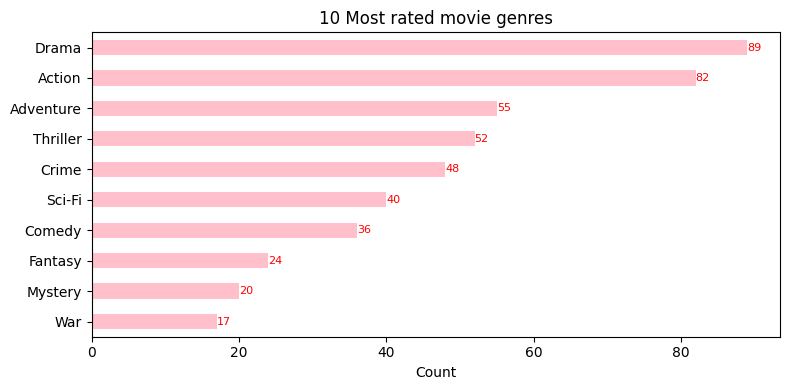

In [110]:
top_ten_genres = genres_ratings['genres'].value_counts().nlargest(10).sort_values()
fig, ax = plt.subplots(figsize=(8,4))
top_ten_genres.plot(kind='barh', xlabel='Count', color='pink', title = '10 Most rated movie genres', ax=ax)
ax.bar_label(ax.containers[0], color='red', fontsize=8)
plt.tight_layout()
plt.show()

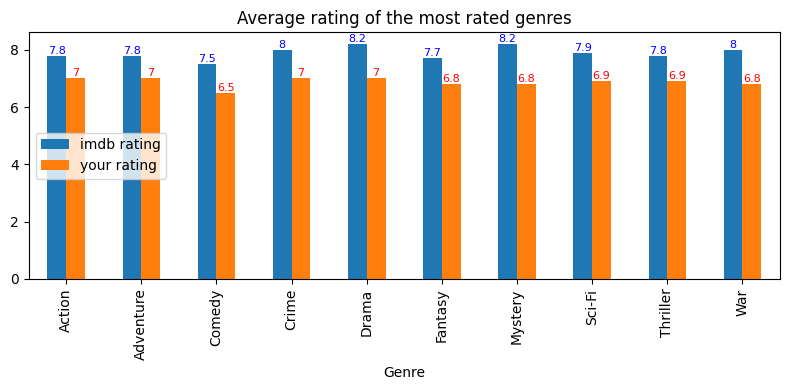

In [111]:
#Avg IMDB rating vs My avg rating for the Top 10 genres rated (avoids niche genres)
top_ten_genres_avg = genres_ratings[genres_ratings['genres'].isin(top_ten_genres.index)]
top_ten_genres_avg = top_ten_genres_avg.groupby('genres')[['imdb rating', 'your rating']].mean().round(1)
fig, ax = plt.subplots(figsize=(8,4))
top_ten_genres_avg.plot(kind='bar', xlabel='Genre', title = 'Average rating of the most rated genres', ax=ax)
ax.bar_label(ax.containers[0], color='blue', fontsize=8)
ax.bar_label(ax.containers[1], color='red', fontsize=8)
ax.legend(loc=6)
plt.tight_layout()
plt.show()

In [85]:
# Which TV Series have I rated 10?
top_rated_tvseries = tvseries[tvseries['your rating'] == 10]
print(top_rated_tvseries[['date rated', 'title', 'release date']].to_string(index=False))

date rated                             title release date
2022-09-29                  Better Call Saul   2015-02-08
2022-07-29                              Dark   2017-09-09
2017-09-01 It's Always Sunny in Philadelphia   2005-08-04
2016-12-16                         Westworld   2016-09-30
2016-12-16                    Rick and Morty   2013-12-02
2014-06-02                            Ramzor   2008-03-24
2013-04-20                        The Office   2005-03-24
2013-03-27                          Seinfeld   1989-05-06
2012-09-08                      Breaking Bad   2008-01-20


In [86]:
print('Out of {} TV Series rated, I rated {} a 10 ({:.1f}%).'.format(tvseries.shape[0], top_rated_tvseries.title.count(), top_rated_tvseries.title.count()/tvseries.shape[0]*100))

Out of 77 TV Series rated, I rated 9 a 10 (11.7%).


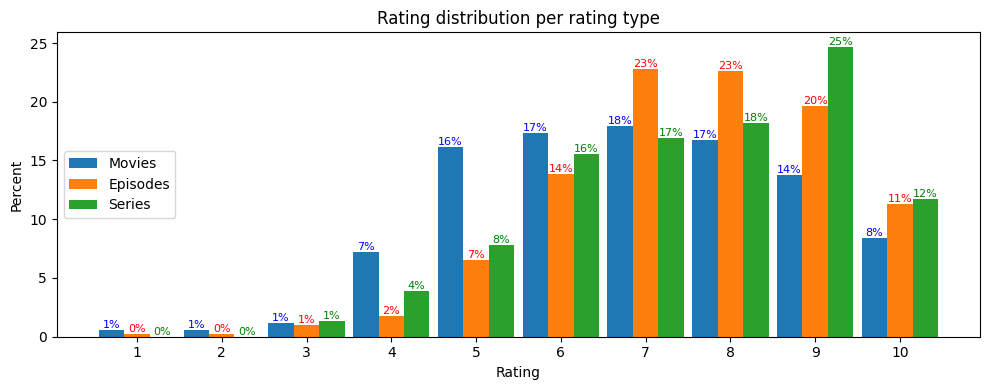

In [114]:
# Comparing rating distributions between movies, episodes and TV shows.
# Each color sums to 100%, distribution by category, not rating.
fig, ax = plt.subplots(figsize=(10,4))
x_axis = np.arange(1,11)
movies_x = movies['your rating'].value_counts(normalize=True).sort_index()*100
tveps_x = tveps['your rating'].value_counts(normalize=True).sort_index()*100
tvseries_x = tvseries['your rating'].value_counts(normalize=True).sort_index()*100
# I didn't rate any TV Series 1 or 2, the following two lines adjust this so missing values are included in the chart.
ratings = dict.fromkeys(set(range(1, 10)).difference(tvseries_x.index), 0)
tvseries_x = tvseries_x.combine(pd.Series(ratings), max, 0)

width = 0.3
ax.bar(x_axis-width, movies_x, width, label = 'Movies')
ax.bar(x_axis, tveps_x, width, label = 'Episodes')
ax.bar(x_axis+width, tvseries_x, width, label = 'Series')
ax.bar_label(ax.containers[0], color='blue', fmt='%.f%%', fontsize=8)
ax.bar_label(ax.containers[1], color='red', fmt='%.f%%', fontsize=8)
ax.bar_label(ax.containers[2], color='green', fmt='%.f%%', fontsize=8)
ax.set_xticks(x_axis)
ax.set_xlabel('Rating')
ax.set_ylabel('Percent')
ax.set_title('Rating distribution per rating type')
ax.legend(loc=6)
plt.tight_layout()
plt.show()

In [88]:
# Reviewing Episode Data:
# "Series : Episode Name" is the current format for episode titles, so I create a new column for the Episode name, and split the title to be the series title.
tveps['episode title'] = tveps['title']
tveps['title'] = tveps['title'].apply(lambda x: x.split(":")[0])

In [116]:
# Let's focus on TV Shows where I rated over 40 episodes:
eps_rated = tveps['title'].value_counts().loc[lambda x: x>40].sort_values(ascending=False).reset_index(name='episode count').rename(columns={'index': 'title'})
print(eps_rated.head().to_string(index=False))

                            title  episode count
                       The Office            188
                         Seinfeld            172
It's Always Sunny in Philadelphia            159
                        Entourage             96
                 The Walking Dead             91


In [90]:
# TV Shows with the highest count of episodes rated 10:
eps_rated_ten = tveps[(tveps['your rating'] == 10) & (tveps['title'].isin(eps_rated['title']))]
eps_rated_ten = eps_rated_ten['title'].value_counts().sort_values(ascending=False).reset_index(name='rated 10 count').rename(columns={'index': 'title'})
print(eps_rated_ten.head().to_string(index=False))

                            title  rated 10 count
                         Seinfeld              30
                  Game of Thrones              19
                     Breaking Bad              15
                   Rick and Morty              13
It's Always Sunny in Philadelphia              11


In [91]:
# Creating a new df with the ratio of episodes rated 10 out of all of the Series episodes:
eps_rated_ten_normalized = pd.merge(eps_rated, eps_rated_ten, on='title')
eps_rated_ten_normalized['percent rated 10'] = eps_rated_ten_normalized['rated 10 count']/eps_rated_ten_normalized['episode count']*100
eps_rated_ten_normalized = eps_rated_ten_normalized.sort_values(by='episode count', ascending=False)
print(eps_rated_ten_normalized.head().to_string(index=False))

                            title  episode count  rated 10 count  percent rated 10
                       The Office            188               4          2.127660
                         Seinfeld            172              30         17.441860
It's Always Sunny in Philadelphia            159              11          6.918239
                        Entourage             96               1          1.041667
                 The Walking Dead             91               5          5.494505


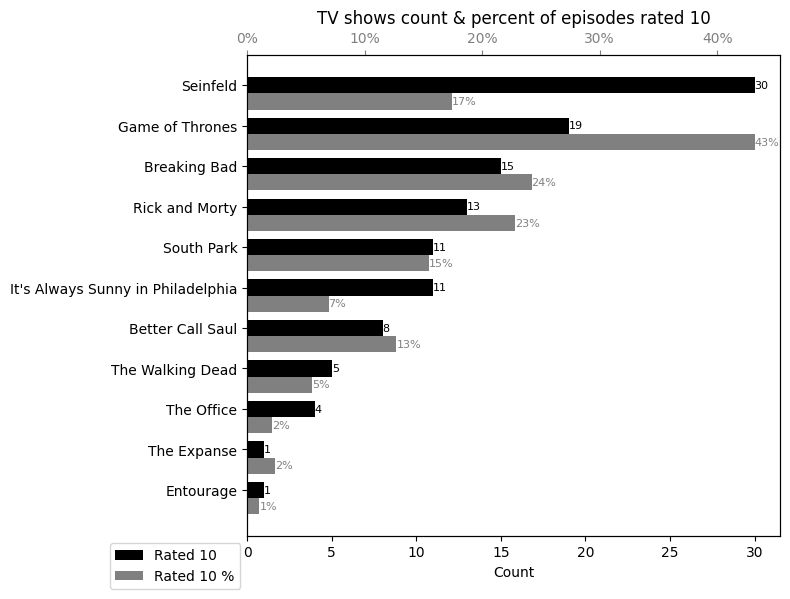

In [118]:
import matplotlib.ticker as mtick
# Plotting the above: number of episodes rated 10 and their ratio of the total episodes rated:
eps_rated_ten_normalized = eps_rated_ten_normalized.sort_values(by='rated 10 count')
fig, ax = plt.subplots(figsize=(8,6))
# Y is an Array for horizontal bar position
Y = np.arange(len(eps_rated_ten_normalized['title']))
height = 0.4
ax.barh(Y, 'rated 10 count', height, label = 'Rated 10', color='black', data=eps_rated_ten_normalized)
ax.bar_label(ax.containers[0], color='black', fontsize=8)
ax.set_xlabel('Count')
# Secondary Y Axis for % of total eps rated 10:
ax2 = ax.twiny()
ax2.barh(Y-0.4, 'percent rated 10', height, label = 'Rated 10 %', color='gray', data=eps_rated_ten_normalized)
ax2.bar_label(ax2.containers[0], color='gray', fmt='%.f%%', fontsize=8)
x2ticks = mtick.FormatStrFormatter('%.0f%%')
ax2.xaxis.set_major_formatter(x2ticks)
ax2.tick_params(axis='x', colors='gray')
ax.set_title('TV shows count & percent of episodes rated 10')
# Setting y-axis ticks and tick labels
ax.set_yticks(Y)
ax.set_yticklabels(np.array(eps_rated_ten_normalized['title']))
fig.legend(bbox_to_anchor=(0,0), bbox_transform=ax.transAxes)
plt.tight_layout()
plt.show()
# Seinfeld has the most episodes rated 10, but Game of Thrones has the highest ratio.

In [93]:
def plot_series(tvshow):
    """Plot a series imdb rating compared to my rating, by episode."""
    tvshow = tvshow.lower()
    custom_show = tveps[tveps['title'].str.lower() == tvshow].sort_values(by='release date')
    custom_show.index = range(1, custom_show.shape[0]+1) #Index set as episode number
    fig, ax = plt.subplots(figsize=(12,4))
    custom_show.plot.line(use_index=True, y=['your rating','imdb rating'], xlabel='Episode', ylabel='Rating', label=['My Rating','IMDB Rating'], ax=ax)
    ax.set_xticks(np.arange(1, custom_show.shape[0]+1, 5))
    ax.set_xlim(1,custom_show.shape[0]+1)
    ax.set_yticks([i for i in range(11)])
    ax.set_ylim(1,10.5)
    ax.set_title(tvshow.title() + ': Rating By Episode')
    imdb_avg = [np.mean(custom_show['imdb rating'])]*custom_show.shape[0]
    my_avg = [np.mean(custom_show['your rating'])]*custom_show.shape[0]
    ax.plot(imdb_avg, color='red', lw=2, ls='--', label="IMDB Average")
    ax.plot(my_avg, color='purple', lw=2, ls='--', label="My Average")
    plt.legend(loc=0)
    plt.tight_layout()
    plt.show()

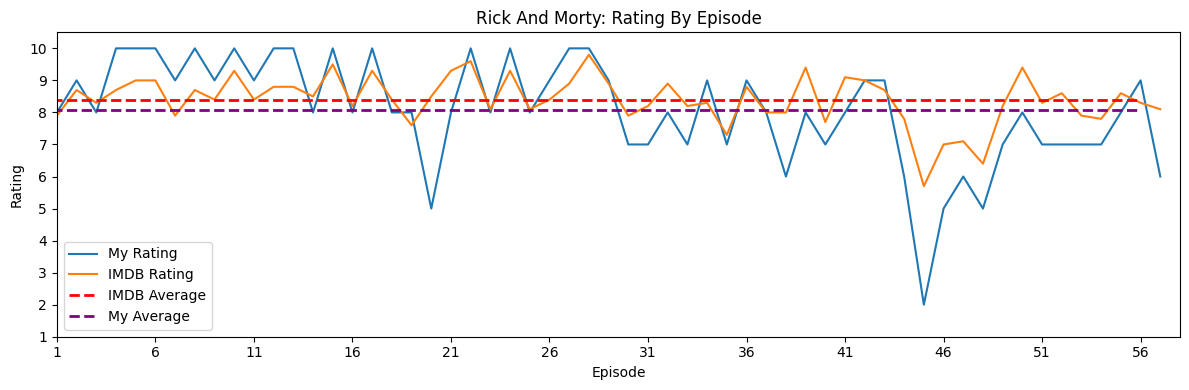

In [94]:
# Type a series name to plot:
plot_series("rick and morty")

In [95]:
def rating_by_year(tvshow):
    """Plot a series average episode rating by year, IMDB compared to my rating."""
    tvshow = tvshow.lower()
    custom_show = tveps[tveps['title'].str.lower() == tvshow].groupby('year')[['imdb rating', 'your rating']].mean().round(1)
    fig, ax = plt.subplots(figsize=(8,4))
    custom_show.plot(kind='bar', y=['imdb rating','your rating'], xlabel='year', ylabel='Rating', label=['IMDB Rating', 'My Rating'], ax=ax)
    ax.set_title(tvshow.title() + ': Average Episode Rating By Year')
    ax.set_yticks([i for i in range(11)])
    ax.bar_label(ax.containers[0], color='blue', fontsize=8)
    ax.bar_label(ax.containers[1], color='red', fontsize=8)
    plt.legend(loc=3)
    plt.tight_layout()
    plt.show()
#def a func to plot show rating by year / season

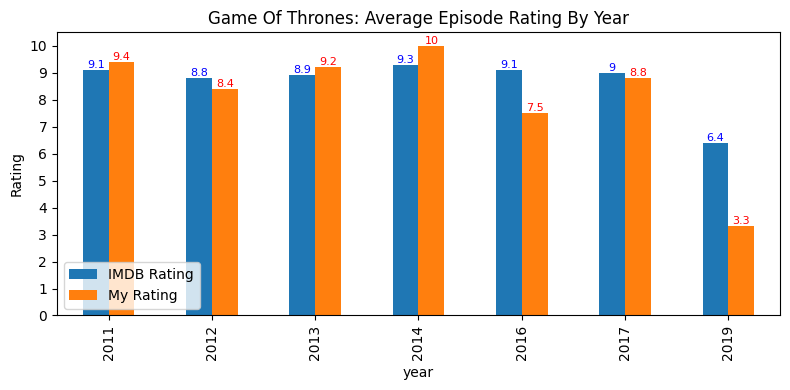

In [96]:
# Type a series name to plot:
rating_by_year("game of thrones")
# Worst ending ever :(

In [120]:
# Average episode rating per show, for shows I rated over 40 episodes.
series_episodes_avg = tveps[tveps['title'].isin(eps_rated['title'])].groupby('title')[['imdb rating', 'your rating']].mean().round(1)
series_episodes_avg = series_episodes_avg.rename(columns={'imdb rating': 'imdb ep avg', 'your rating': 'my ep avg'})
print(series_episodes_avg.head().to_string())

                                   imdb ep avg  my ep avg
title                                                    
Better Call Saul                           8.8        8.2
Breaking Bad                               9.0        8.6
Entourage                                  8.2        7.4
Game of Thrones                            8.7        8.3
It's Always Sunny in Philadelphia          8.4        7.2


In [123]:
# Ratings for the series themselves where I rated  > 40 eps
series_i_rated = tvseries[tvseries['title'].isin(eps_rated['title'])]
series_i_rated = series_i_rated[['title','imdb rating', 'your rating']]
print(series_i_rated.head().to_string(index=False))

           title  imdb rating  your rating
Better Call Saul          8.9           10
     Kupa Rashit          8.7            9
      South Park          8.7            9
 Game of Thrones          9.2            7
     The Expanse          8.5            8


In [124]:
# Merging the Series rating (IMDB/mine) with the average episode rating.
series_episodes_merge = pd.merge(series_episodes_avg, series_i_rated, on='title')
series_episodes_merge = series_episodes_merge.set_index('title')
series_episodes_merge.describe()
# Looks like I am more forgiving when rating the shows themselves, more strict when rating the episodes.
# Makes sense considering some great shows have awful episodes, e.g The Office has some very hard to watch cringe eps :)
# My average series rating matches IMDB for this small sample of shows with over 40 ratings.

,imdb ep avg,my ep avg,imdb rating,your rating
count,12.000000,12.000000,12.000000,12.000000
mean,8.366667,7.608333,8.833333,8.833333
std,0.322866,0.633114,0.374975,1.466804
min,8.000000,6.600000,8.100000,6.000000
25%,8.100000,7.175000,8.650000,7.750000
50%,8.350000,7.350000,8.850000,9.500000
75%,8.475000,8.200000,9.050000,10.000000
max,9.000000,8.600000,9.500000,10.000000


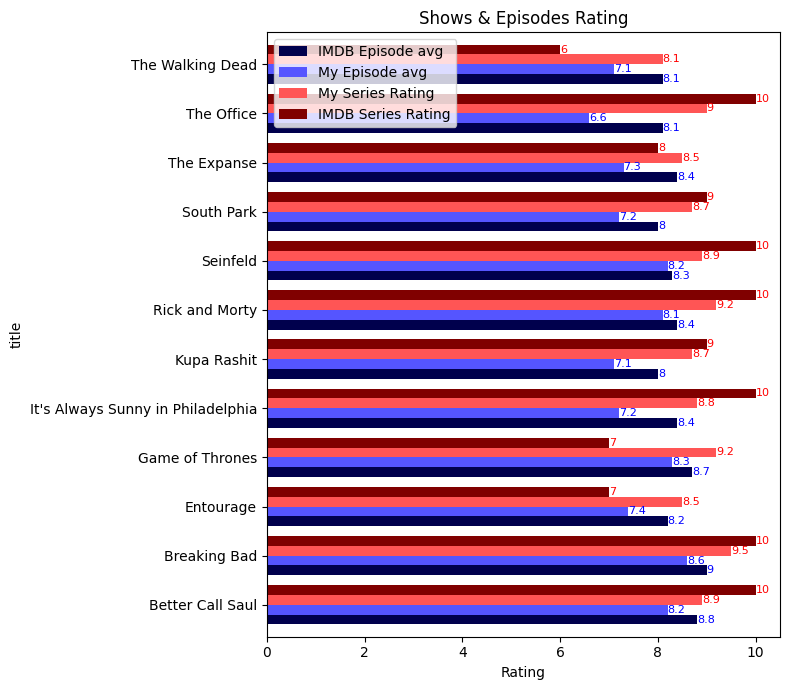

In [126]:
# Plotting the difference between a show's rating compared to the average episode:
fig, ax = plt.subplots(figsize=(8,7))
series_episodes_merge.plot(kind='barh', xlabel='Rating', width=0.8, colormap='seismic', title = 'Shows & Episodes Rating', ax=ax)
ax.bar_label(ax.containers[0], color='blue', fontsize=8)
ax.bar_label(ax.containers[1], color='blue', fontsize=8)
ax.bar_label(ax.containers[2], color='red', fontsize=8)
ax.bar_label(ax.containers[3], color='red', fontsize=8)
plt.legend(labels=['IMDB Episode avg', 'My Episode avg', 'My Series Rating', 'IMDB Series Rating'], loc=2)
plt.tight_layout()
plt.show()